In [ ]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from manifold import mirror_vecs
import jax.numpy as jnp
import jax
from sphere import Sphere as S

# https://opendatadocs.dmi.govcloud.dk/Data/Climate_Data_Stations
api_key = "1c818f3c-6b69-4ea9-bca3-0e47fdf44494"
url = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"
params = {
    "parameterId": "wind_dir",
    "stationId": "06081",
    "datetime": "2020-11-01T00:00:00Z/2024-11-07T23:59:59Z",
    "api-key": api_key,
}


def get_next(links):
    for link in links:
        if link["rel"] == "next":
            return link["href"]
    return None


response = requests.get(url, params=params)

collected_features = []

for i in range(100):
    data = response.json()
    collected_features.extend(data["features"])

    next_url = get_next(data["links"])
    if next_url:
        print("Getting next page", next_url)
        response = requests.get(next_url)
    else:
        break


df = pd.DataFrame(map(lambda x: x["properties"], collected_features))
df["timestamp"] = pd.to_datetime(df["created"])

df["angle"] = df["value"] / 360 * 2 * np.pi
df["x"] = np.cos(df["angle"])
df["y"] = np.sin(df["angle"])

midday_df = (
    df[df["timestamp"].dt.hour == 12].groupby(df["timestamp"].dt.floor("h")).first()
)

In [66]:
midday_df = (
    df[
        (df["timestamp"].dt.hour == 12)
        & (df["timestamp"].dt.year == 2024)
        & (df["timestamp"].dt.month >= 6)
    ]
    .groupby(df["timestamp"].dt.floor("h"))
    .first()
)

<Axes: xlabel='timestamp', ylabel='value'>

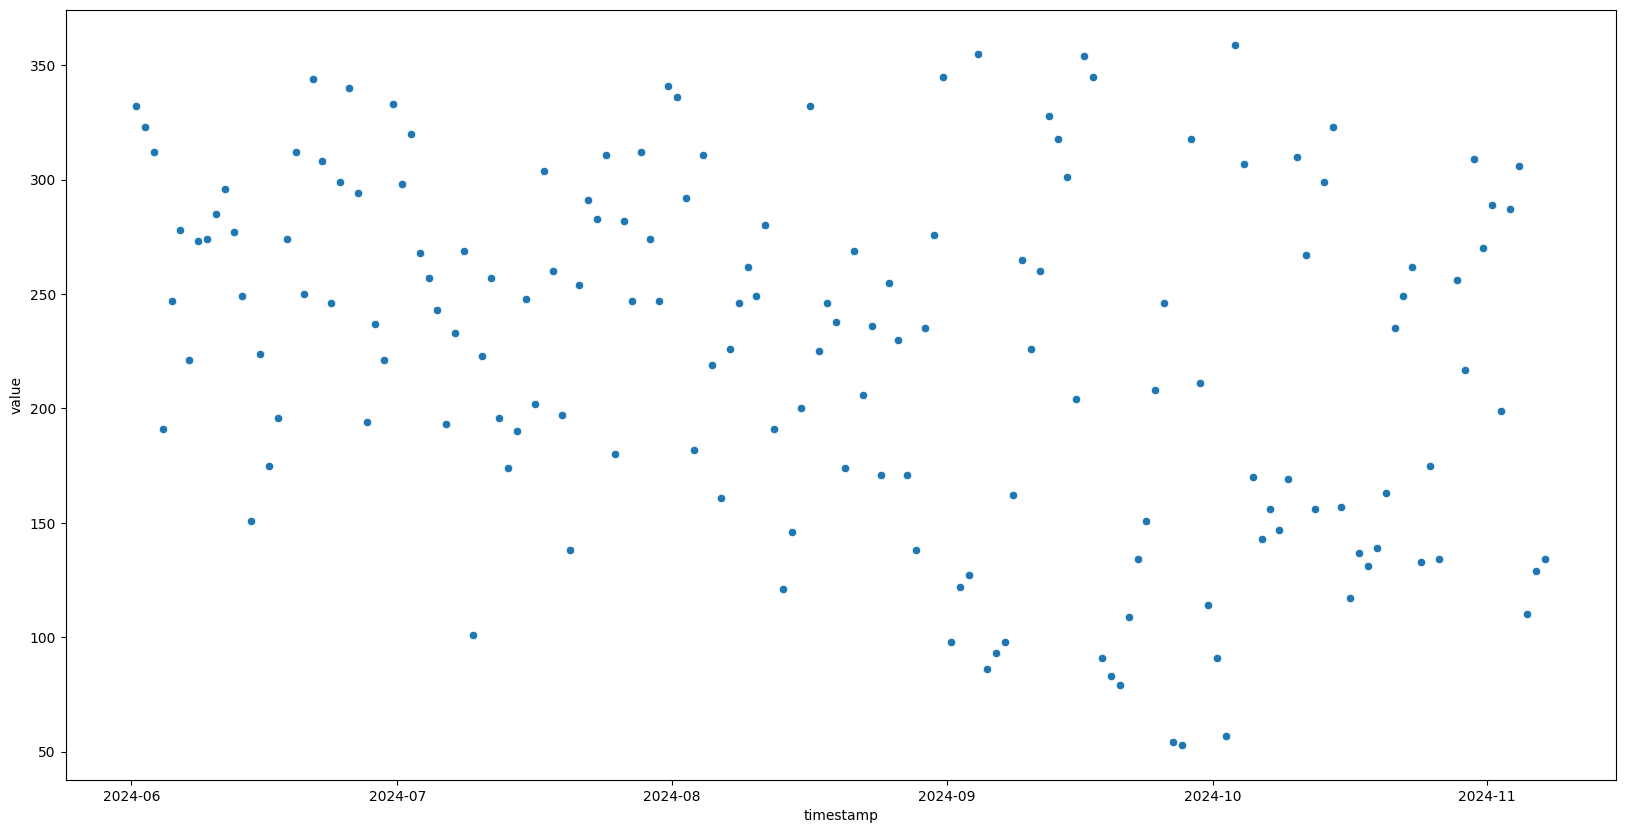

In [68]:
plt.figure(figsize=(20, 10))
sns.scatterplot(midday_df, x="timestamp", y="value")

In [87]:
df

,created,observed,parameterId,stationId,value,timestamp,angle,x,y
0,2024-11-07T15:53:10.686608Z,2024-11-07T15:50:00Z,wind_dir,06081,143.0,2024-11-07 15:53:10.686608+00:00,2.495821,-0.798636,0.601815
1,2024-11-07T15:43:11.079891Z,2024-11-07T15:40:00Z,wind_dir,06081,137.0,2024-11-07 15:43:11.079891+00:00,2.391101,-0.731354,0.681998
2,2024-11-07T15:33:03.671922Z,2024-11-07T15:30:00Z,wind_dir,06081,143.0,2024-11-07 15:33:03.671922+00:00,2.495821,-0.798636,0.601815
3,2024-11-07T15:23:04.090549Z,2024-11-07T15:20:00Z,wind_dir,06081,148.0,2024-11-07 15:23:04.090549+00:00,2.583087,-0.848048,0.529919
4,2024-11-07T15:14:06.782230Z,2024-11-07T15:10:00Z,wind_dir,06081,142.0,2024-11-07 15:14:06.782230+00:00,2.478368,-0.788011,0.615661
...,...,...,...,...,...,...,...,...,...
97995,2023-07-08T07:40:52.496336Z,2022-12-21T12:40:00Z,wind_dir,06081,185.0,2023-07-08 07:40:52.496336+00:00,3.228859,-0.996195,-0.087156
97996,2023-07-08T07:40:52.473073Z,2022-12-21T12:30:00Z,wind_dir,06081,190.0,2023-07-08 07:40:52.473073+00:00,3.316126,-0.984808,-0.173648
97997,2023-07-08T07:40:52.450430Z,2022-12-21T12:20:00Z,wind_dir,06081,198.0,2023-07-08 07:40:52.450430+00:00,3.455752,-0.951057,-0.309017
97998,2023-07-08T07:40:52.427566Z,2022-12-21T12:10:00Z,wind_dir,06081,199.0,2023-07-08 07:40:52.427566+00:00,3.473205,-0.945519,-0.325568


159


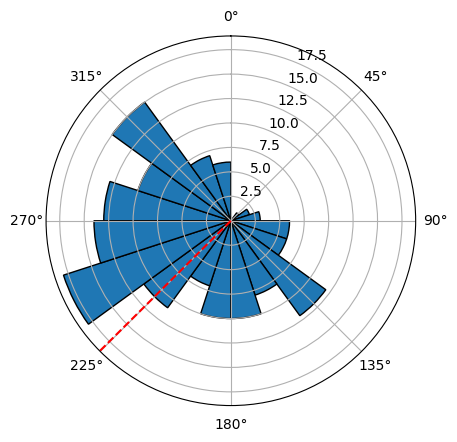

In [85]:
midday_df = (
    df[
        (df["timestamp"].dt.hour == 12)
        & (df["timestamp"].dt.year == 2024)
        & (df["timestamp"].dt.month >= 6)
    ]
    .groupby(df["timestamp"].dt.floor("h"))
    .first()
)
print(len(midday_df))
X = jnp.array(midday_df[["x", "y"]].values)
mu_hat = S.frechet_mean(X, None, max_iter=100)
mu_hat_angle = np.arctan2(mu_hat[1], mu_hat[0]) + 2 * np.pi
data = 2 * np.pi * midday_df["value"].values / 360
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
num_bins = 20  # Number of bins for the histogram
theta_bins = np.linspace(0, 2 * np.pi, num_bins + 1)
counts, _ = np.histogram(data, bins=theta_bins)
bars = ax.bar(
    theta_bins[:-1], counts, width=(2 * np.pi) / num_bins, align="edge", edgecolor="k"
)
ax.axvline(mu_hat_angle, color="r", linestyle="--")
ax.set_theta_zero_location("N")  # 0 at the top (North)
ax.set_theta_direction(-1)  # Clockwise direction

plt.show()

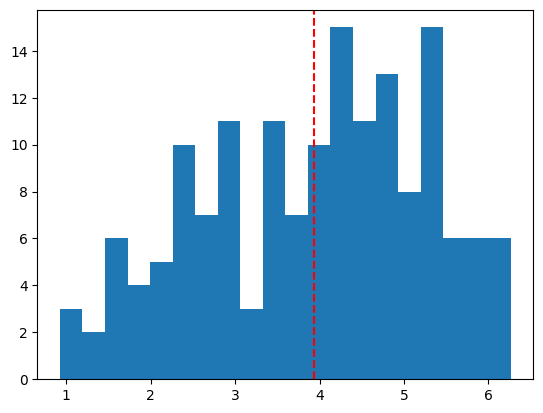

In [86]:
plt.hist(data, bins=20)
plt.axvline(mu_hat_angle, color="r", linestyle="--")

p-value =  0.05379999801516533


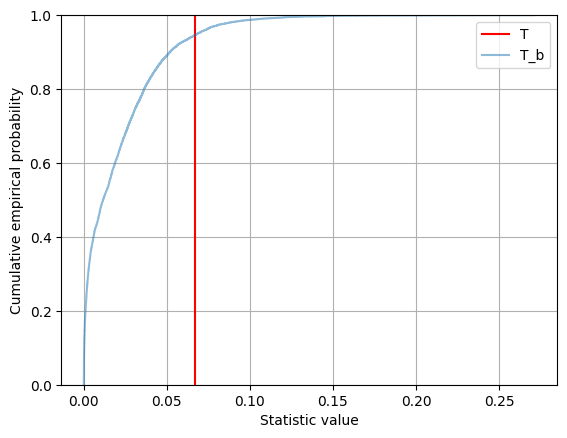

In [70]:
def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


num_bootstrap = 10_000


def proc_inner(M, x, mu_0, key):
    fm_key, key = jax.random.split(key, 2)
    x_mirrored = mirror_vecs(M, mu_0, x)

    mu_hat = M.frechet_mean(x, fm_key)
    t = M.dist(mu_hat, mu_0) ** 2

    def fun(it_key):
        z_key, fm_key = jax.random.split(it_key)
        x_b = mixture(z_key, x, x_mirrored, 1 / 2)
        mu_hat_b = M.frechet_mean(x_b, fm_key)
        return M.dist(mu_hat_b, mu_0) ** 2

    t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))
    return t, t_b


t, t_b = proc_inner(
    S,
    X,
    jnp.array([np.cos(-2 * np.pi / 3), np.sin(-2 * np.pi / 3)]),
    jax.random.PRNGKey(np.random.randint(0, 2**32)),
)

plt.axvline(t, color="red", label="T")
plt.ecdf(t_b[~np.isnan(t_b)], alpha=0.5, label="T_b")
plt.xlabel("Statistic value")
plt.ylabel("Cumulative empirical probability")
plt.grid("on")
plt.legend()
print("p-value = ", (t_b >= t).mean().item())